In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [4]:
df = pd.read_csv("monthly_sales.csv",
                 index_col='Date',
                 parse_dates=True) 
df.head

<bound method NDFrame.head of             Qty
Date           
2015-06-01  750
2015-07-01  450
2015-08-01   50
2015-09-01  100
2015-10-01  150
...         ...
2023-12-01  297
2024-01-01   43
2024-02-01  395
2024-03-01  166
2024-04-01  215

[106 rows x 1 columns]>

<Axes: xlabel='Date'>

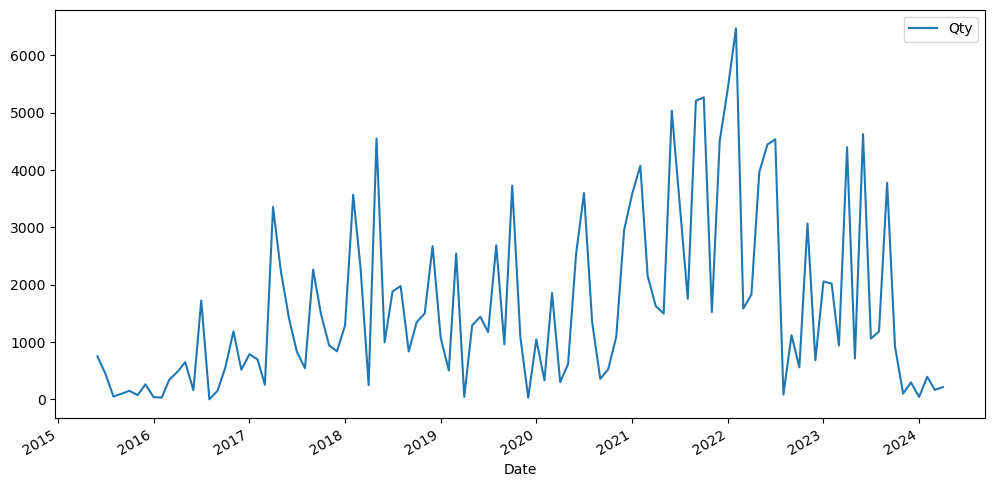

In [3]:
df.plot(figsize=(12,6))

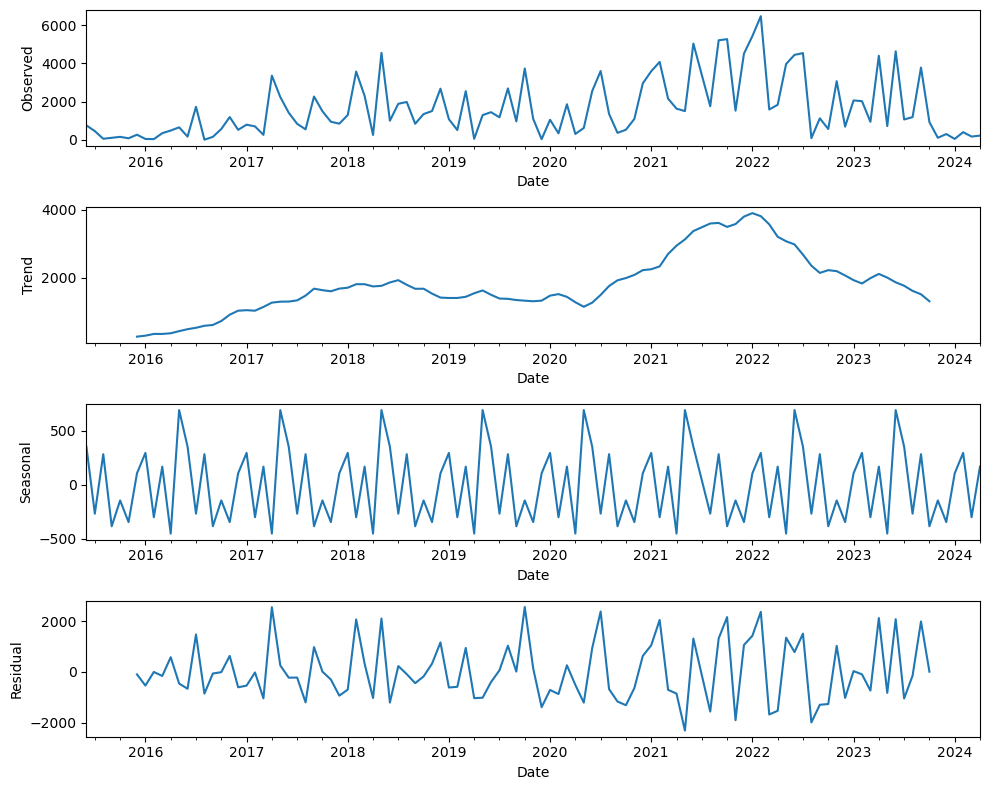

In [4]:
df = pd.read_csv("monthly_sales.csv",
                 index_col='Date',
                 parse_dates=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period('M')  # Set frequency to monthly
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['Qty'], period=12)  # Adjust period based on your data
# Plot results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
results.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
results.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
results.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
results.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [5]:
train =df.iloc[0:85]
test = df.iloc[85:]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
 
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=n_input,
                                batch_size=1)
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=n_input,
                                batch_size=1)
tset_generator = TimeseriesGenerator(scaled_test,
                                    scaled_test,
                                    length=n_input,
                                    batch_size=1)

Given the Array: 
[0.11561051 0.06924266 0.00741886]
Predict this y: 
 [[0.01514683]]


In [8]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Define the model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()

# Train the model
model.fit(generator, epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
73/73 [==============================] - 1s 2ms/step - loss: 0.0726
Epoch 2/10
73/73 [==============================] - 0s 2ms/step - loss: 0.0438
Epoch 3/10
73/73 [==============================] - 0s 2ms/step - loss: 0.0453
Epoch 4/10
73/73 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 5/10
73/73 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 6/10
73/73 [==============================] - 0

In [9]:
train_loss = model.evaluate(generator, verbose=0)
print(f'Training Loss: {train_loss}')

Training Loss: 0.0410228967666626


In [10]:
predictions = model.predict(generator, verbose=0)

for i in range(len(predictions)):
    print(f'Predicted: {predictions[i][0]}, Actual: {scaled_train[i+n_input]}')


Predicted: 0.14465877413749695, Actual: [0.02472952]
Predicted: 0.1414945125579834, Actual: [0.26630603]
Predicted: 0.15922877192497253, Actual: [0.]
Predicted: 0.15852293372154236, Actual: [0.02287481]
Predicted: 0.15852409601211548, Actual: [0.0862442]
Predicted: 0.16266122460365295, Actual: [0.18315301]
Predicted: 0.17482134699821472, Actual: [0.0797527]
Predicted: 0.17766883969306946, Actual: [0.12163833]
Predicted: 0.18455085158348083, Actual: [0.10741886]
Predicted: 0.18973946571350098, Actual: [0.03910355]
Predicted: 0.18724331259727478, Actual: [0.5187017]
Predicted: 0.2185576856136322, Actual: [0.34513138]
Predicted: 0.24206611514091492, Actual: [0.21839258]
Predicted: 0.2583572268486023, Actual: [0.12828439]
Predicted: 0.25518742203712463, Actual: [0.08377125]
Predicted: 0.25796014070510864, Actual: [0.34945904]
Predicted: 0.28021135926246643, Actual: [0.22998454]
Predicted: 0.28927916288375854, Actual: [0.14544049]
Predicted: 0.28587254881858826, Actual: [0.12952087]
Predict

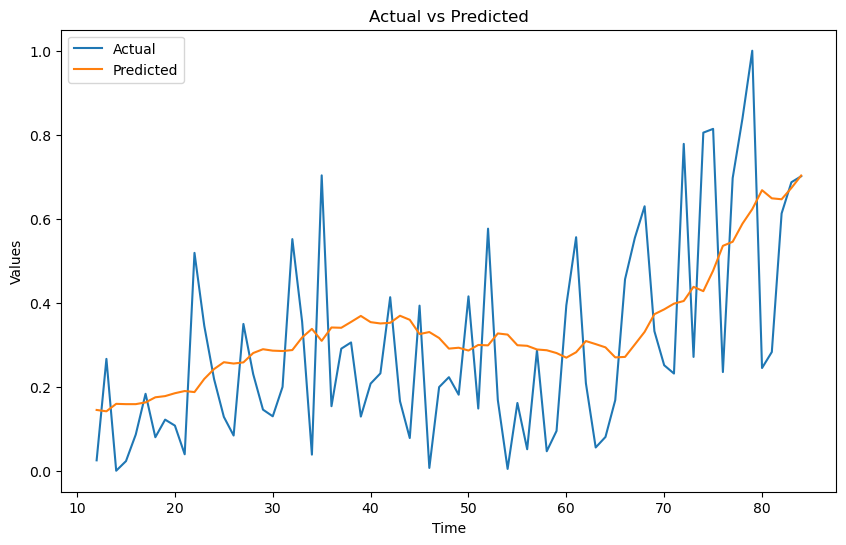

In [11]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(generator, verbose=0)

# Flatten the predictions array if necessary
predictions = predictions.flatten()

# Convert predictions back to the original scale if necessary
# predictions = scaler.inverse_transform(predictions)

# Ensure predictions and actual values have matching lengths
actual_values = scaled_train[n_input:len(predictions) + n_input]

# Prepare the full range for plotting
full_range = range(n_input, len(actual_values) + n_input)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n_input, len(actual_values) + n_input), actual_values, label='Actual')
plt.plot(range(n_input, len(predictions) + n_input), predictions, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()


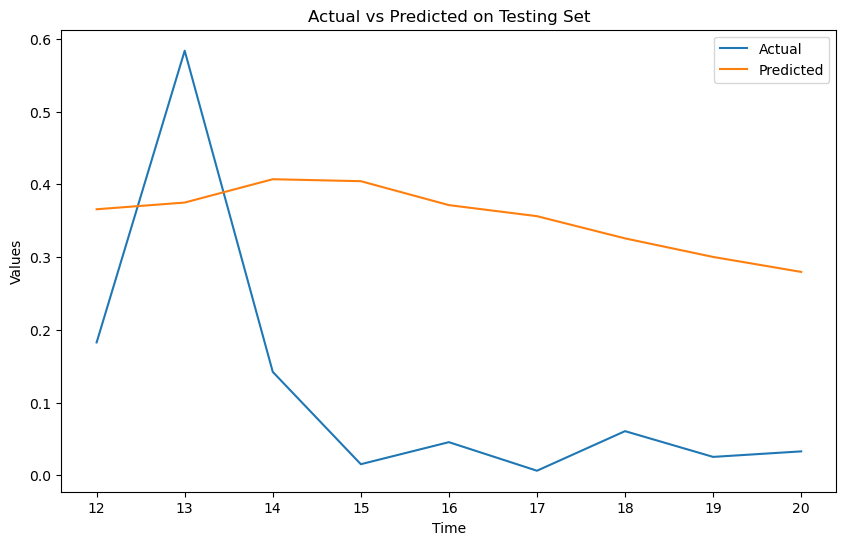

In [12]:
test_generator = TimeseriesGenerator(scaled_test,
                                    scaled_test,
                                    length=n_input,
                                    batch_size=1)
# Assuming you have already defined your test data generator similar to your training generator
test_predictions = model.predict(test_generator, verbose=0)

# Flatten the predictions array if necessary
test_predictions = test_predictions.flatten()

# Ensure test predictions and actual values have matching lengths
test_actual_values = scaled_test[n_input:len(test_predictions) + n_input]
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the full range for plotting
test_full_range = range(n_input, len(test_actual_values) + n_input)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_full_range, test_actual_values, label='Actual')
plt.plot(test_full_range, test_predictions, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted on Testing Set")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()


Epoch 1/600
103/103 [==============================] - 1s 836us/step - loss: 0.0539
Epoch 2/600
103/103 [==============================] - 0s 834us/step - loss: 0.0489
Epoch 3/600
103/103 [==============================] - 0s 836us/step - loss: 0.0484
Epoch 4/600
103/103 [==============================] - 0s 865us/step - loss: 0.0493
Epoch 5/600
103/103 [==============================] - 0s 852us/step - loss: 0.0483
Epoch 6/600
103/103 [==============================] - 0s 914us/step - loss: 0.0489
Epoch 7/600
103/103 [==============================] - 0s 768us/step - loss: 0.0478
Epoch 8/600
103/103 [==============================] - 0s 913us/step - loss: 0.0468
Epoch 9/600
103/103 [==============================] - 0s 849us/step - loss: 0.0493
Epoch 10/600
103/103 [==============================] - 0s 840us/step - loss: 0.0484
Epoch 11/600
103/103 [==============================] - 0s 899us/step - loss: 0.0459
Epoch 12/600
103/103 [==============================] - 0s 859us/step - lo

C:\Users\Irving\AppData\Local\Temp\ipykernel_36856\3591721353.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=len(scaled_data), freq='M')


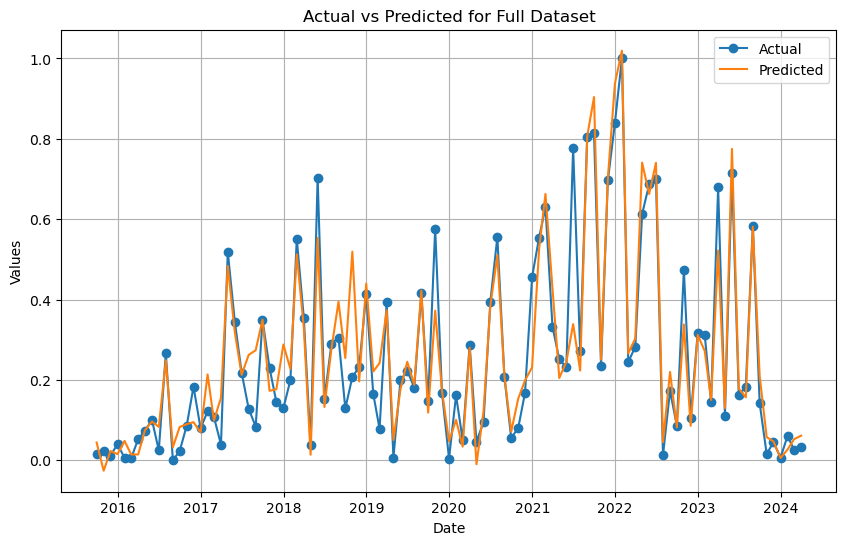

In [21]:
scaled_data = np.concatenate((scaled_train, scaled_test), axis=0)

# Example parameters (replace with your actual values)
n_input = 3  # Number of time steps to look back
n_features = 1  # Number of features (in this case, it's just quantity)

# Create generator for full dataset
full_generator = TimeseriesGenerator(scaled_data, scaled_data,
                                     length=n_input, batch_size=1)

# Define the model architecture
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model (adjust epochs as needed)
model.fit(full_generator, epochs=600, verbose=1)

# Make predictions for the full dataset
predictions = model.predict(full_generator)

# Flatten predictions and actual values arrays if necessary
predictions = predictions.flatten()
actual_values = scaled_data[n_input:]

# Create date range for plotting
start_date = pd.Timestamp('2015-06-01')
dates = pd.date_range(start=start_date, periods=len(scaled_data), freq='M')

# Plot the results with dates
plt.figure(figsize=(10, 6))
plt.plot(dates[n_input:], actual_values, marker='o', label='Actual')
plt.plot(dates[n_input:], predictions, linestyle='-', label='Predicted')
plt.title("Actual vs Predicted for Full Dataset")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/300


C:\Users\Irving\AppData\Local\Temp\ipykernel_36856\2344621910.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=len(scaled_data) + forecast_period, freq='M')


103/103 [==============================] - 1s 912us/step - loss: 0.0713
Epoch 2/300
103/103 [==============================] - 0s 808us/step - loss: 0.0507
Epoch 3/300
103/103 [==============================] - 0s 802us/step - loss: 0.0485
Epoch 4/300
103/103 [==============================] - 0s 812us/step - loss: 0.0489
Epoch 5/300
103/103 [==============================] - 0s 915us/step - loss: 0.0479
Epoch 6/300
103/103 [==============================] - 0s 905us/step - loss: 0.0481
Epoch 7/300
103/103 [==============================] - 0s 881us/step - loss: 0.0469
Epoch 8/300
103/103 [==============================] - 0s 880us/step - loss: 0.0494
Epoch 9/300
103/103 [==============================] - 0s 870us/step - loss: 0.0468
Epoch 10/300
103/103 [==============================] - 0s 857us/step - loss: 0.0475
Epoch 11/300
103/103 [==============================] - 0s 868us/step - loss: 0.0466
Epoch 12/300
103/103 [==============================] - 0s 859us/step - loss: 0.0472
E

C:\Users\Irving\AppData\Local\Temp\ipykernel_36856\2344621910.py:45: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=dates[len(scaled_data)], periods=forecast_period, freq='M')


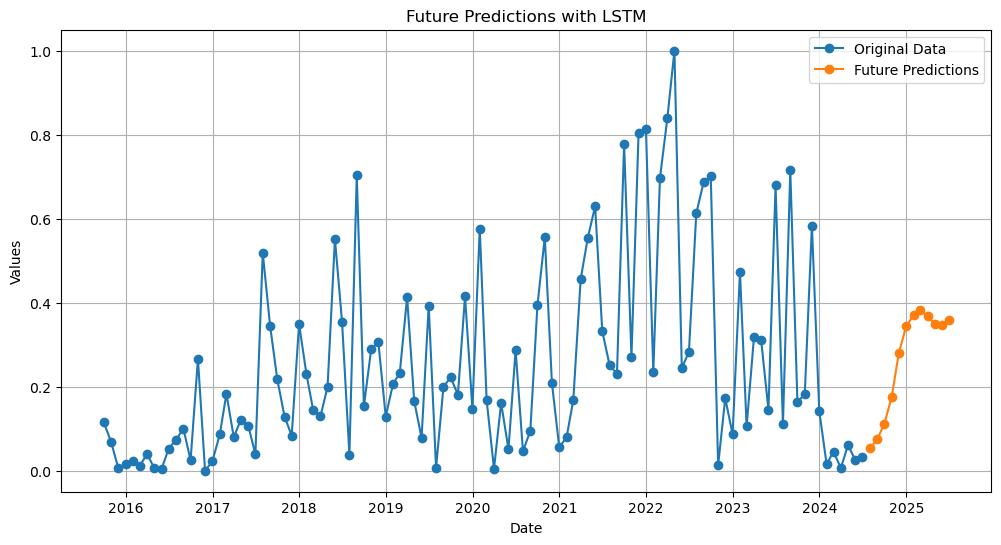

In [19]:
forecast_period = 12  # Number of future time steps to predict (1 year)

# Example parameters (replace with your actual values)
n_input = 3  # Number of time steps to look back
n_features = 1  # Number of features (in this case, it's just quantity)

# Create example dates
start_date = pd.Timestamp.now() - pd.DateOffset(months=len(scaled_data))
dates = pd.date_range(start=start_date, periods=len(scaled_data) + forecast_period, freq='M')

# Prepare input data for predicting future values
last_sequence = scaled_data[-n_input:]  # Last n_input values from scaled_data
last_sequence = last_sequence.reshape((1, n_input, n_features))  # Reshape for model input

# Define the model architecture
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# Example using a simple generator for demonstration
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)
model.fit(generator, epochs=300, verbose=1)

# Generate predictions for future values
future_predictions = []
current_sequence = last_sequence.copy()

for _ in range(forecast_period):
    future_pred = model.predict(current_sequence)[0]
    future_predictions.append(future_pred)
    current_sequence = np.append(current_sequence[:, 1:, :], [[future_pred]], axis=1)

# Inverse transform the predictions if you used scaling (example with MinMaxScaler)
# future_predictions = scaler.inverse_transform(future_predictions)

# Plotting the results with dates
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(dates[:len(scaled_data)], scaled_data, marker='o', label='Original Data')

# Plot future predictions
future_dates = pd.date_range(start=dates[len(scaled_data)], periods=forecast_period, freq='M')
plt.plot(future_dates, future_predictions, linestyle='-', marker='o', label='Future Predictions')

plt.title('Future Predictions with LSTM')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()